In [66]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
from pmdarima import auto_arima, model_selection, ARIMA
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta, date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import joblib

In [67]:
%run datatools.py

# Read endogenous and exogenous data and filter country/dates

In [68]:
# We filter the country, the variable to predict and the dates

country = 'United States'
variable = 'new_cases_'
col = variable + country
datecol = 'date'
initialdate = '2020-01-01'   # first day of the year, where our data starts
#enddate = str(date.fromordinal(date.today().toordinal()-1))   # yesterday's date: last day of available data

In [69]:
# We read the endogenous data (coronavirus data) (for now, from a local file) and extract last date of

covid_ctry_varR = pd.read_csv('./data/endogenous.csv', parse_dates=[datecol], index_col=[datecol], usecols=[datecol, col])
enddate = str(date.fromordinal(covid_ctry_varR.tail(1).index[0].toordinal())) # last day of available data

In [70]:
# We now read the exogenous data (for now, from a local file):

exogenous = pd.read_csv('./data/exogenous.csv', parse_dates=[datecol], index_col=[datecol])

# We now need to filter the country:
exogenous_ctryR = exogenous.loc[:, exogenous.columns.str.contains(country)]

In [71]:
# We check that effectively endogenous and exogenous data have the same length:
print(len(covid_ctry_varR) == len(exogenous_ctryR))

True


# Visualize endogenous and exogenous data and normalize it all

(267, 1) (267, 13)


<AxesSubplot:xlabel='date'>

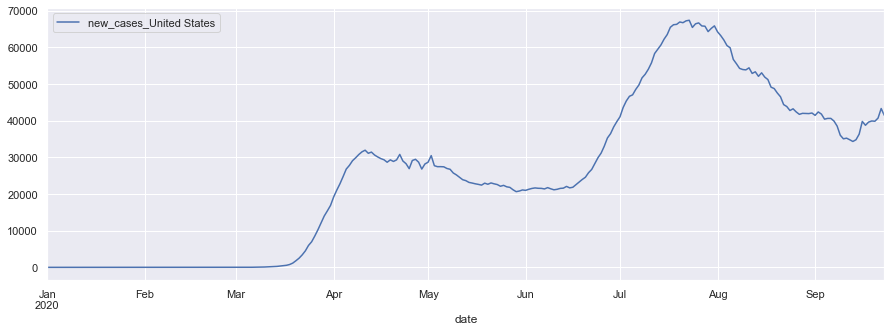

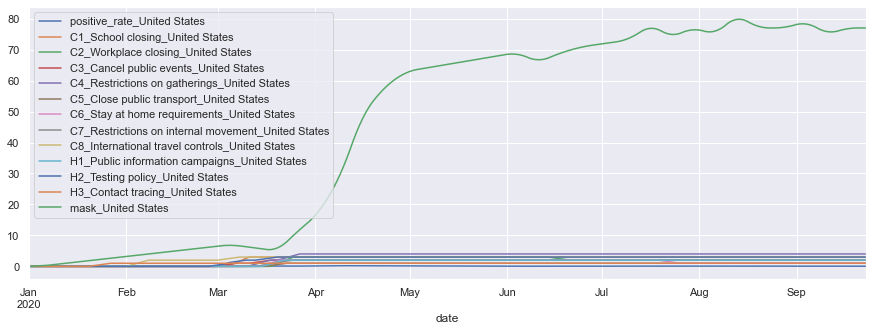

In [72]:
print(covid_ctry_varR.shape, exogenous_ctryR.shape)
covid_ctry_varR.plot()
exogenous_ctryR.plot()

In [73]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogenous_ctryR)
scaled_input = pd.DataFrame(scaled_input, index=exogenous_ctryR.index, columns=exogenous_ctryR.columns)
X = scaled_input

In [74]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR)
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.columns[0])
y = scaled_output.resample('1D').sum()

(267,) (267, 13)


<AxesSubplot:xlabel='date'>

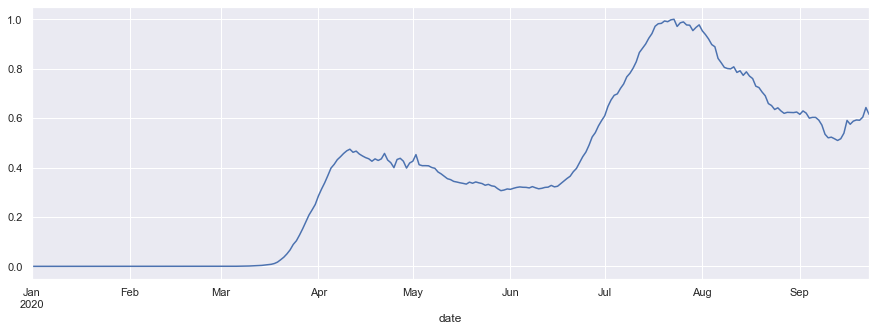

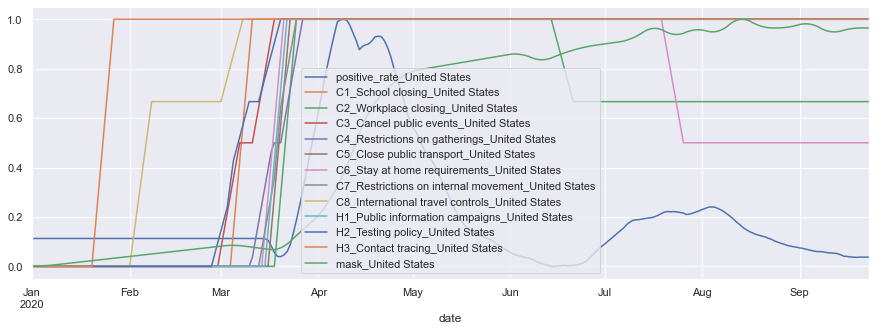

In [75]:
print(y.shape, X.shape)
y.plot()
X.plot()

# Split endogenous and exogenous data into train/test

In [76]:
# We are going to use 85% for training, since most of the series is the big curve, 
# and then we have the smaller changes in coronavirus cases towards the end
train_size = int(len(covid_ctry_varR) * 0.85)
test_size = len(covid_ctry_varR) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [77]:
train_size, test_size

(226, 41)

# Stationarity: estimate differencing term (d)

In [78]:
# Performing different tests to estimate best value of 'd'

## Adf Test
d_adf = ndiffs(y_train, test='adf')
print('ADF test: ', d_adf)

# KPSS test
d_kpss = ndiffs(y_train, test='kpss')
print('KPSS test: ', d_kpss)

# PP test:
d_pp = ndiffs(y_train, test='pp')
print('PP test: ', d_pp)

ADF test:  0
KPSS test:  1
PP test:  1


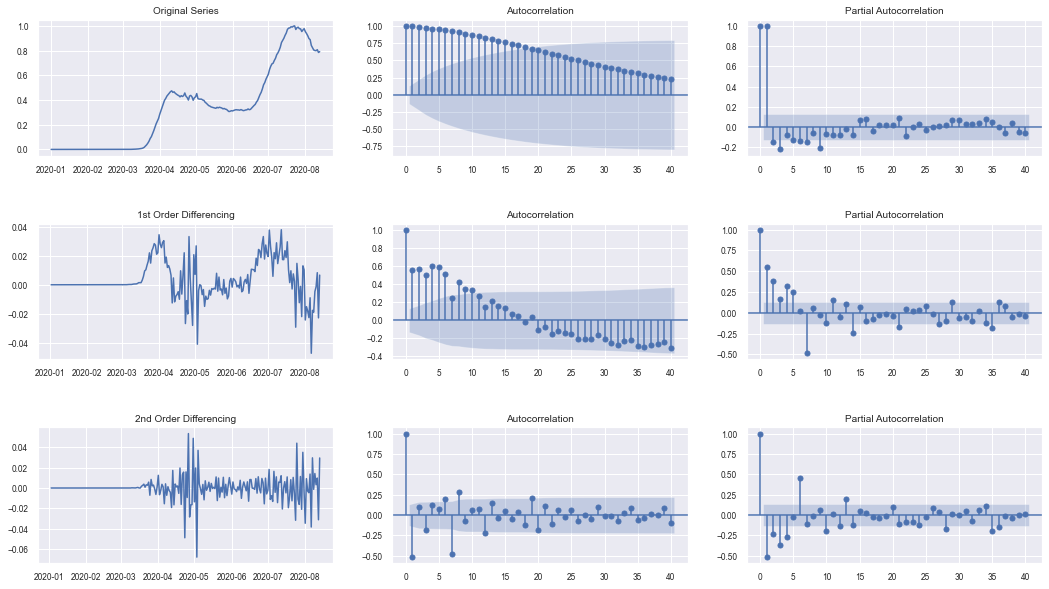

In [79]:
# Plotting ACF and PACF for different 'd' values (d=1, d=2):

plot_acf_pacf(y_train)
sns.reset_defaults
plt.rcParams["figure.figsize"] = (15, 5)

**Consider if d=1 would be best, since the ACF/PACF for d=2 turns largely negative at lag 1, which is an indication that the series may be over-differenced**

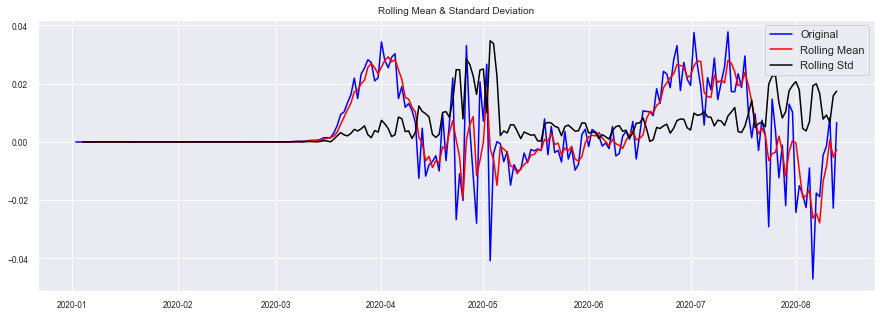

Result of Dicky-Fuller Test


Test Statistic           -3.047668
p-value                   0.030676
#Lags Used               13.000000
#Observations Used      211.000000
Critical Value (1%)      -3.461727
Critical Value (5%)      -2.875337
Critical Value (10%)     -2.574124
dtype: float64

In [80]:
# Test stationarity and print results of ADF test:
test_stationarity(y_train.diff().dropna())

# Estimate orders p and q of ARIMA model, using auto_arima

In [81]:
# Perform different auto_arima searches and sort results by lowest AIC:
result_table = autoarimas(y_train, X_train)
result_table

,parameters,aic
0,"(0, 1, 5)",-1460.611573
1,"(4, 2, 0)",-1444.685587
2,"(1, 1, 1)",-1434.721364
3,"(1, 2, 1)",-1423.208902


# Perform cross-validation on top 3 models and select the best. Then train and fit SARIMAX model with the one that gave best results

In [82]:
# Extract top 3 models from previous step (first 3 elements, since they are sorted):
model1 = ARIMA(order=result_table.iloc[0,0])
model2 = ARIMA(order=result_table.iloc[1,0])
model3 = ARIMA(order=result_table.iloc[2,0])

In [83]:
best_order = cross_val(y_train, X_train, model1, model2, model3)

Model 1 CV scores: ['0.0151', '0.0539', '0.1130', '0.1201', '0.0995', '0.0609', '0.1030', '0.0175', '0.0515', '0.0759', '0.1109']
Model 2 CV scores: ['0.0268', '0.0389', '0.1028', '0.0436', '0.0185', '0.0602', '0.0157', '0.0732', '0.1301', '0.1217', '0.0868']
Model 3 CV scores: ['0.0131', '0.0527', '0.1129', '0.1403', '0.1138', '0.0630', '0.0832', '0.0195', '0.0563', '0.0885', '0.1061']
Lowest average MAE: 0.06530712648372894 (model2)
Best model order: (4, 2, 0)


                                  SARIMAX Results                                  
Dep. Variable:     new_cases_United States   No. Observations:                  226
Model:                    SARIMAX(4, 2, 0)   Log Likelihood                 740.343
Date:                     Thu, 24 Sep 2020   AIC                          -1444.686
Time:                             18:56:25   BIC                          -1383.276
Sample:                         01-01-2020   HQIC                         -1419.898
                              - 08-13-2020                                         
Covariance Type:                       opg                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
positive_rate_United States                            0.2659      0.045      5.969      0

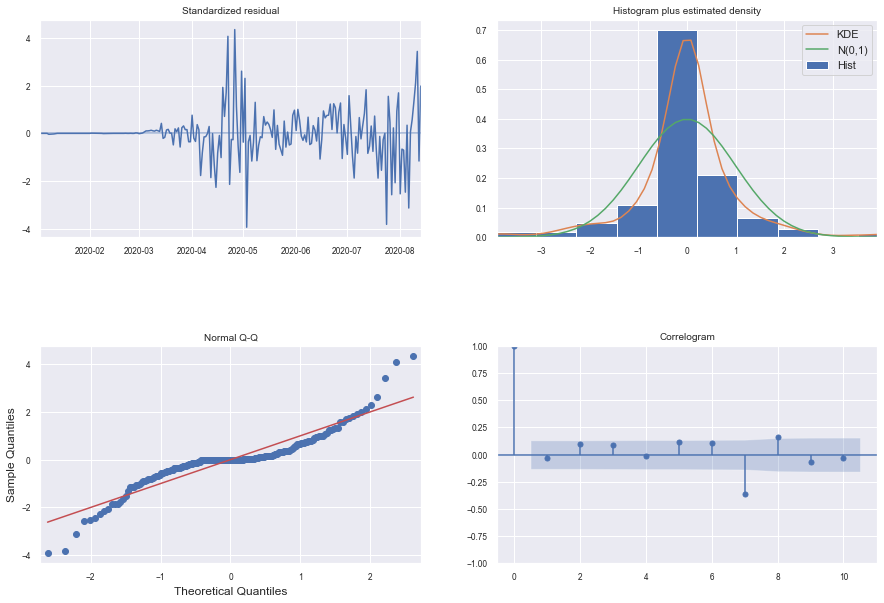

In [84]:
best_model = sm.tsa.statespace.SARIMAX(y_train, order=best_order, exog=X_train)
results = best_model.fit(full_output=False, disp=False)
print(results.summary())
results.plot_diagnostics(figsize=(15,10));

# Perform/plot in-sample prediction and out-of-sample forecast and evaluate model MAE

In [85]:
train_size, test_size, X_test.shape

(226, 41, (41, 13))

Test MAE (0-1 scale): 0.063


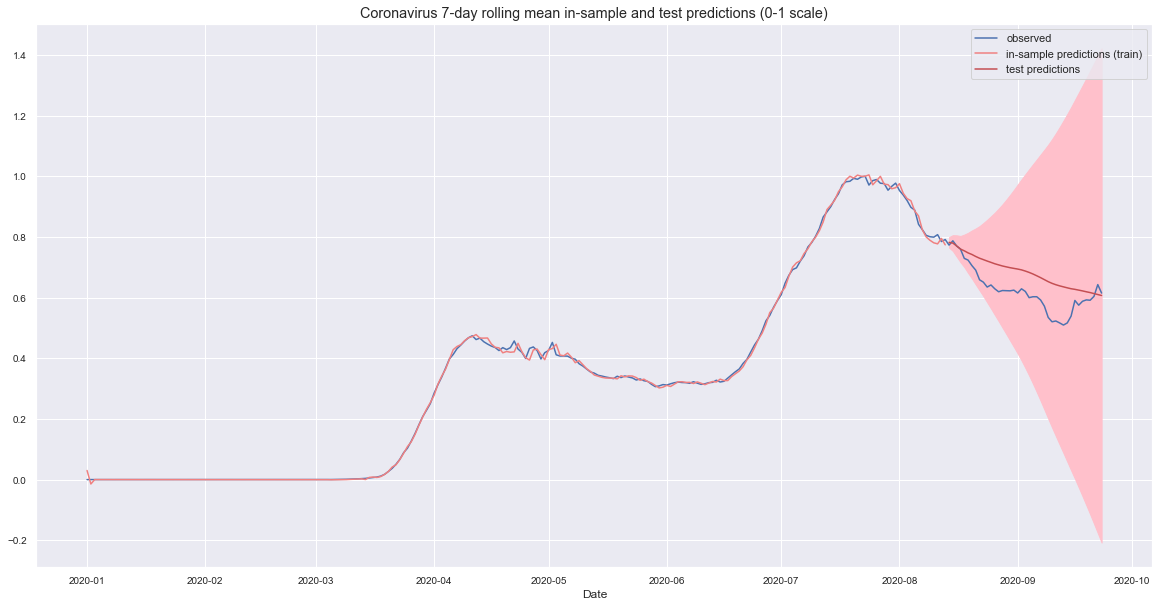

In [86]:
in_predictions, mean_forecast = in_out_fcast_plot(results, test_size, y, y_test, X_train, X_test)

# set title and show plot
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (0-1 scale)')
plt.show()

# Scale data back to original values and plot

In [87]:
trainPredict = sc_out.inverse_transform(in_predictions.values.reshape(-1,1))
trainPredictS = pd.Series(trainPredict.flatten(), index=covid_ctry_varR[:train_size].index, name=covid_ctry_varR.columns[0])

In [88]:
testPredict = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
testPredictS = pd.Series(testPredict.flatten(), index=covid_ctry_varR[train_size:].index, name=covid_ctry_varR.columns[0])
testPredictS = testPredictS.clip(lower=0)

In [89]:
mae_orig = mean_absolute_error(covid_ctry_varR[train_size:], testPredictS)
mae_orig_perc = mae_orig / covid_ctry_varR[train_size:].mean()[0]
print("Test MAE (original scale): {:.1f}".format(mae_orig))

Test MAE (original scale): 4222.3


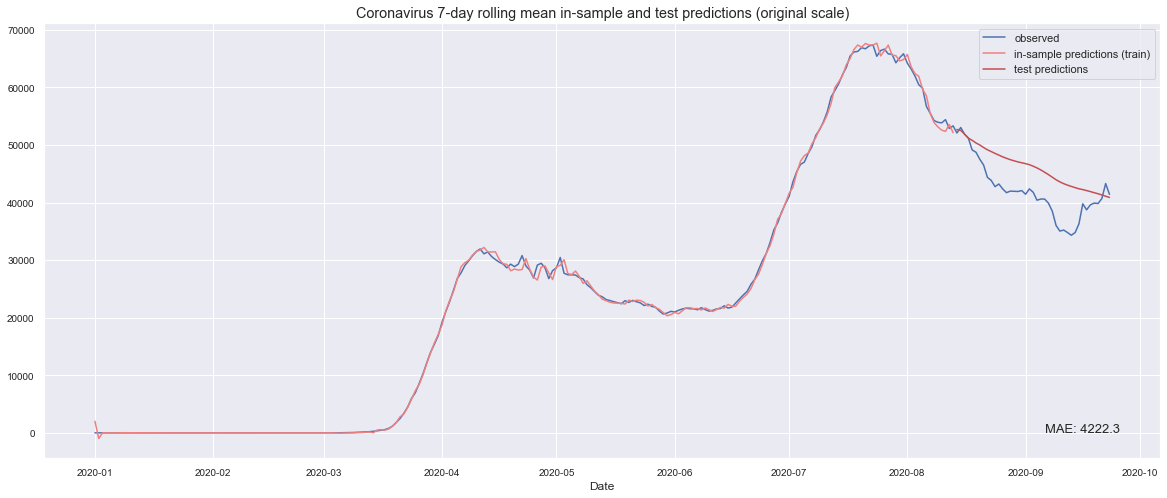

In [90]:
# plot the data
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(trainPredictS.index, trainPredictS, color='lightcoral', label='in-sample predictions (train)')

plt.plot(testPredictS.index, testPredictS, color='r', label='test predictions')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (original scale)')
plt.text(0.82, 0.17, 'MAE: {:.1f}'.format(mae_orig), transform = plt.gcf().transFigure, fontsize=13)
plt.rcParams["figure.figsize"] = (20, 8)
plt.legend()
plt.show()

# Save model so we can then update with future values

In [91]:
# Set model name
filename = './models/' + country.replace(" ", "") + '_' + variable + 'model.pkl'

# Pickle it. This is commented since the models are saved when running the 'model_pipeline_all.py' file
#joblib.dump(results, filename)

In [92]:
# Load the model back in
#loaded_model = joblib.load(filename)

In [93]:
#loaded_model.summary()

# Update model with test observations, to get it ready for future forecasts

In [94]:
# Update model with test sample and re-fit parameters:
#res_updated = results.append(y_test, exog=X_test, refit=True, full_output=False, disp=False)

In [95]:
# Update model with test sample:
res_updated = results.append(y_test, exog=X_test, full_output=False, disp=False)

                                  SARIMAX Results                                  
Dep. Variable:     new_cases_United States   No. Observations:                  267
Model:                    SARIMAX(4, 2, 0)   Log Likelihood                 819.550
Date:                     Thu, 24 Sep 2020   AIC                          -1603.100
Time:                             18:56:27   BIC                          -1538.665
Sample:                         01-01-2020   HQIC                         -1577.211
                              - 09-23-2020                                         
Covariance Type:                       opg                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
positive_rate_United States                            0.2659      0.045      5.969      0

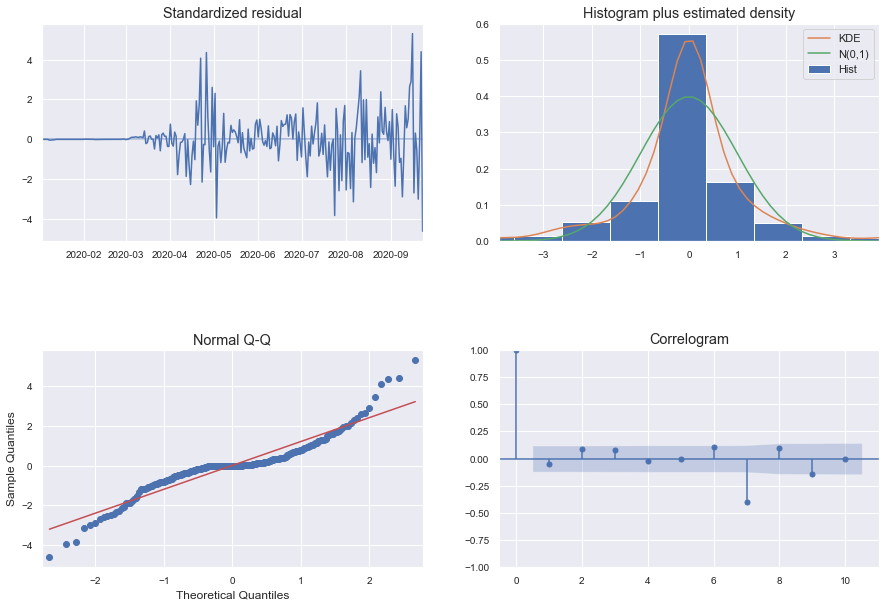

In [96]:
# Print summary of updated model and plot diagnostics, to confirm everything working as expected:
print(res_updated.summary())
res_updated.plot_diagnostics(figsize=(15,10));

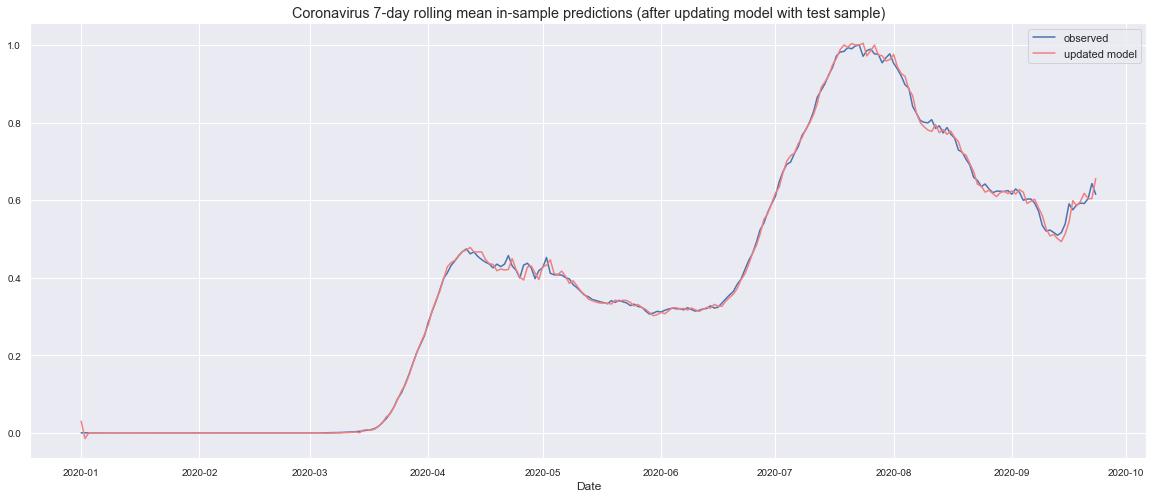

In [97]:
# Plot the updated data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train+test)
plt.plot(res_updated.fittedvalues.index, res_updated.fittedvalues, color='lightcoral', label= 'updated model')
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample predictions (after updating model with test sample)')
plt.legend()
plt.show()

In [98]:
# Save model again, after updating it with test sample:
# This is commented since the models are saved when running the 'model_pipeline_all.py' file

#joblib.dump(res_updated, filename)

# Perform forecast

In [99]:
forecastdays = 14
new_begin = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + 1))
new_date = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + forecastdays))
new_index = pd.date_range(initialdate, new_date, freq='D')
exog_conc = exogenous_ctryR.reindex(new_index).interpolate()

<AxesSubplot:>

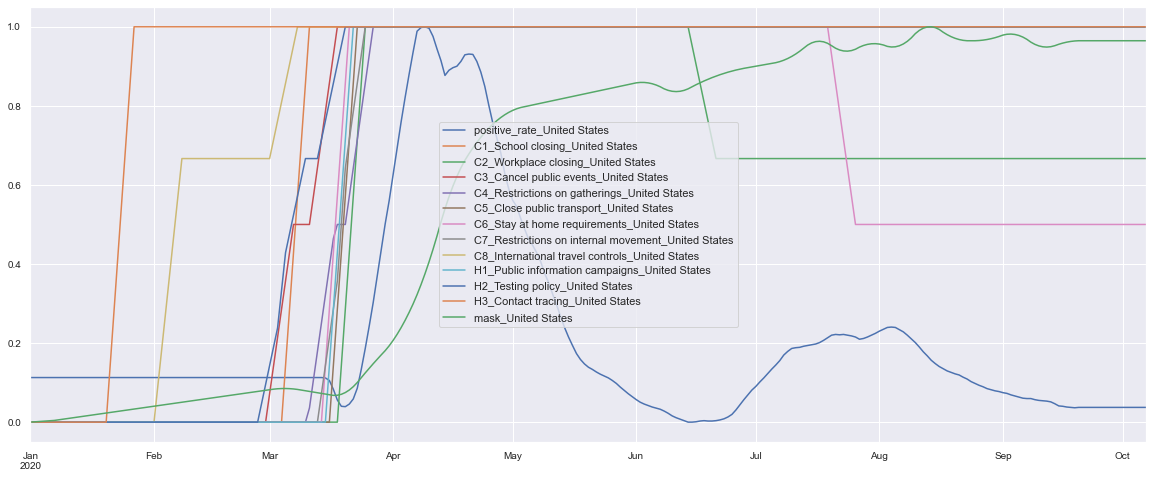

In [100]:
# Re-scale exogenous date with new added days:
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_conc)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_conc.index, columns=exog_conc.columns)
X_fc = scaled_input_fc
X_fc.plot()

[0.62089972 0.62056384 0.6364757  0.64254832 0.63967605 0.64303629
 0.64779996 0.65589575 0.65913703 0.66156965 0.66539587 0.67049095
 0.67560202 0.67925628]


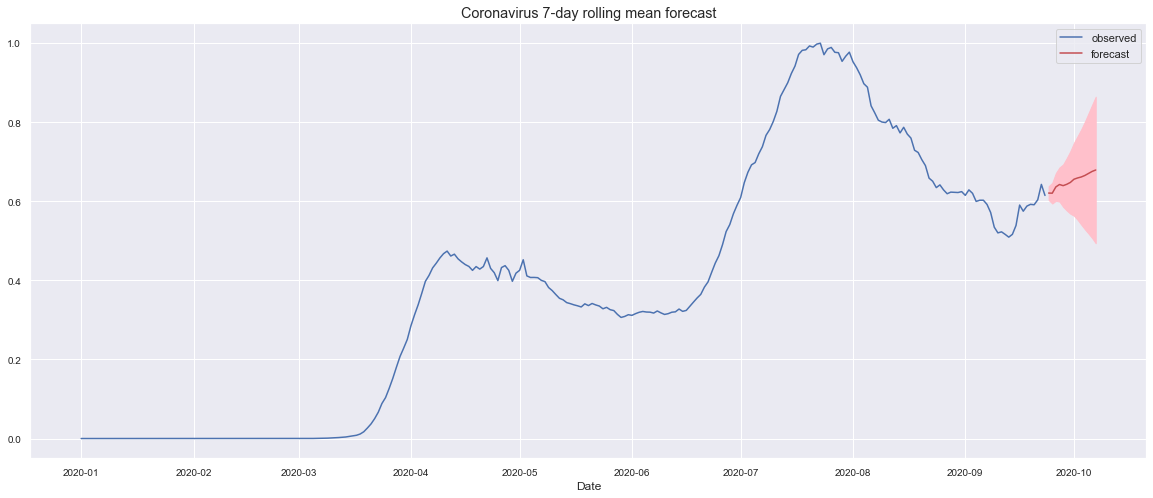

In [101]:
# Generate out of sample forecast

forecast = res_updated.get_forecast(steps=forecastdays, exog=X_fc[new_begin:new_date])

# Extract prediction mean and assign negative values to zero (negative numbers don't make sense here):
mean_forecast = forecast.predicted_mean
mean_forecast = mean_forecast.clip(lower=0)

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower ' + y.name]
upper_limits = confidence_intervals.loc[:,'upper ' + y.name]

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(y.index, y, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast')
plt.legend()
plt.show()

In [102]:
forecast14 = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
forecast14S = pd.Series(forecast14.flatten(), index=mean_forecast.index, name='new_cases_forecast')
forecast14S = forecast14S.clip(lower=0)

forecast14_ll = sc_out.inverse_transform(lower_limits.values.reshape(-1,1))
forecast14_llS = pd.Series(forecast14_ll.flatten(), index=lower_limits.index, name='new_cases_forecast_ll')

forecast14_ul = sc_out.inverse_transform(upper_limits.values.reshape(-1,1))
forecast14_ulS = pd.Series(forecast14_ul.flatten(), index=upper_limits.index, name='new_cases_forecast_ul')

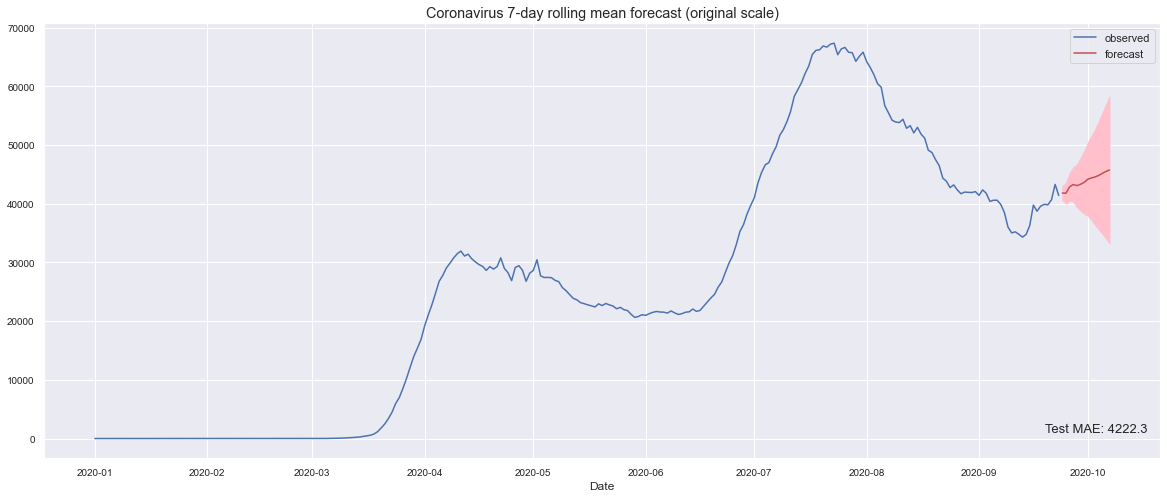

In [103]:
# plot the data
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(forecast14S.index, forecast14S, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(forecast14_llS.index, forecast14_llS, forecast14_ulS, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast (original scale)')
plt.text(0.82, 0.17, 'Test MAE: {:.1f}'.format(mae_orig), transform = plt.gcf().transFigure, fontsize=13)
plt.legend()
plt.show()

In [104]:
# Print forecasted values:

forecast14S_l = ["%.1f" % elem for elem in forecast14S]
print(forecast14S_l)

['41832.2', '41809.6', '42881.6', '43290.8', '43097.3', '43323.7', '43644.6', '44190.0', '44408.4', '44572.3', '44830.1', '45173.4', '45517.7', '45763.9']
